# Dauphine PSL - Master IASD app

# Validation and Interpretability (partie 2)

- Lab duration: 1.30h

- Goals: implementing GradCAM for visual model interpretation

Convolutional Neural Networks (CNNs) are extensively applied in computer vision and are particularly effective for processing grid-like data. Despite their efficacy, it remains challenging to understand the underlying mechanisms of how and why they work. This is due to the fact that they lack decomposability into individually understandable components. In this assignment, we leverage Grad-CAM, a technique that helps identify important regions in an input image for the neural network prediction, which can enhance our comprehension of CNNs.

This lab session has been inspired from Guillaume Charpiat.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image

%matplotlib inline

### Download the Model
We provide you a pretrained model `ResNet-34` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **ResNet-34**: A deep architecture for image classification.

In [2]:
resnet34 = models.resnet34(pretrained=True)
resnet34.eval() # set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 22.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

![ResNet34](https://miro.medium.com/max/1050/1*Y-u7dH4WC-dXyn9jOG4w0w.png)


Input image must be of size (3x224x224).

First convolution layer with maxpool.
Then 4 ResNet blocks.

Output of the last ResNet block is of size (512x7x7).

Average pooling is applied to this layer to have a 1D array of 512 features fed to a linear layer that outputs 1000 values (one for each class). No softmax is present in this case. We have already the raw class score!

In [3]:
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

##classes is a dictionary with the name of each class
print(classes)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course or download directly using the following command line,).<br>
In order to use the pretrained model resnet34, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [4]:
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)

In [5]:
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them

import os
os.mkdir("data")
os.mkdir("data/TP2_images")

!cd data/TP2_images && gdown --quiet  "1Mo3gEKLh07KQhpv29ORiw65hvlYGNO_r"  && unzip TP2_images.zip
dir_path = "data/"
dataset = preprocess_image(dir_path)

Archive:  TP2_images.zip
   creating: .ipynb_checkpoints/
  inflating: 155881293_721e90b57d.jpg  
  inflating: 158850087_3251644046.jpg  
  inflating: 1624593475_146bf1f7ff.jpg  
  inflating: 181748579_01a4611736.jpg  
  inflating: 2068921624_ef0986de13.jpg  
  inflating: 2637374064_fab14ec0b8.jpg  
  inflating: 2749465889_8e62023674.jpg  
  inflating: 2936812850_23bf0d1cfd.jpg  
  inflating: 3532471222_a6d7e3780e.jpg  
  inflating: 3633913271_ee789a3bc4.jpg  
  inflating: 3633949157_f577605ea9.jpg  
  inflating: 3894967408_706f2135c6.jpg  
  inflating: 4020994958_ee0f171e0d.jpg  
  inflating: 4178031069_53cc807d15.jpg  
  inflating: 430941039_63cdefff92.jpg  
  inflating: 481635090_85a1c668ed.jpg  
  inflating: 4872530262_36641b1698.jpg  
  inflating: 490951559_bf34120cd7.jpg  
  inflating: 5233523570_1e0baebe83.jpg  
  inflating: 5635968516_1975a6f8b9.jpg  


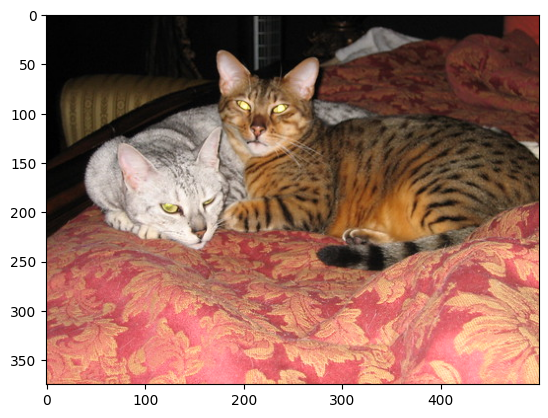

In [6]:
# show the orignal image
index = 5
input_image = Image.open(dataset.imgs[index][0]).convert('RGB')
plt.imshow(input_image)

🛠 **EXERCICE :** Using the pre-trained `resnet34`, compute the top 3 prediction classes of the previous images.

💡 Hint
- you can use the `torch.topk` function


In [7]:
image = dataset[index][0].view(1, 3, 224, 224)

output = resnet34(image)
values, indices = torch.topk(output, 3)
print("Top 3-classes:", indices[0].numpy(), [classes[x] for x in indices[0].numpy()])
print("Raw class scores:", values[0].detach().numpy())

Top 3-classes: [285 281 282] ['Egyptian cat', 'tabby, tabby cat', 'tiger cat']
Raw class scores: [13.175314 11.065537 10.584748]


### Grad-CAM
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude.


* **Hints**:
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully.
 + The pretrained model resnet34 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly.
 + The size of feature maps is 7x7, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

 Class: ‘pug, pug-dog’ | Class: ‘tabby, tabby cat’
- | -
![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/dog.jpg)| ![alt](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/cat.jpg)

### Walk through the GradCAM process :





####**First step**

First we need to get the index of the **last convolutional layer** to get the activation maps. Use the following cell to see the different layers of the network and their depth



In [8]:
for idx, layer in enumerate(resnet34.named_parameters()):
  print(f"index {idx} : {layer[0]}")

index 0 : conv1.weight
index 1 : bn1.weight
index 2 : bn1.bias
index 3 : layer1.0.conv1.weight
index 4 : layer1.0.bn1.weight
index 5 : layer1.0.bn1.bias
index 6 : layer1.0.conv2.weight
index 7 : layer1.0.bn2.weight
index 8 : layer1.0.bn2.bias
index 9 : layer1.1.conv1.weight
index 10 : layer1.1.bn1.weight
index 11 : layer1.1.bn1.bias
index 12 : layer1.1.conv2.weight
index 13 : layer1.1.bn2.weight
index 14 : layer1.1.bn2.bias
index 15 : layer1.2.conv1.weight
index 16 : layer1.2.bn1.weight
index 17 : layer1.2.bn1.bias
index 18 : layer1.2.conv2.weight
index 19 : layer1.2.bn2.weight
index 20 : layer1.2.bn2.bias
index 21 : layer2.0.conv1.weight
index 22 : layer2.0.bn1.weight
index 23 : layer2.0.bn1.bias
index 24 : layer2.0.conv2.weight
index 25 : layer2.0.bn2.weight
index 26 : layer2.0.bn2.bias
index 27 : layer2.0.downsample.0.weight
index 28 : layer2.0.downsample.1.weight
index 29 : layer2.0.downsample.1.bias
index 30 : layer2.1.conv1.weight
index 31 : layer2.1.bn1.weight
index 32 : layer2.

Get the activation maps from last convolution layer resnet34- layer. You can get its index and name from the previous cell.

🛠 **EXERCICE :** For this task, you need to define a hook <code>store_activation_maps</code> that will store the activation maps in a buffer call **activ_last_conv**.

💡 Hint

- refer to the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully
- you can use the `torch.clone` function to store the activations
- you can use `register_buffer` function : [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.forward)




In [9]:
features_conv = nn.Sequential(*list(resnet34.children())[:-2])


activ_last_conv  = None

def store_activation_maps(module, input, output):
    global activ_last_conv
    activ_last_conv  = output




#### <u>**Second step**</u>

🛠 **EXERCICE :**

Define a hook <code>compute_heatmap</code>that will get the gradients outputs of this layer during the backward phase. We compute the mean of values for each map that will represent activations weights :
>
>$$ \alpha_{k}^{c} = \dfrac{1}{Z}\sum_{i}\sum_{j} \dfrac{\partial{y^{c}}}{\partial{A_{ij}^{k}}} $$
>with$ Z = $ number of neurons in the feature map (14x14 here).
>
>Within the same hook, we compute the heatmap as a weighted linear combination of the maps (computed in the forward pass) as follows :
$$ L^{c} = ReLU(\sum_{k} \alpha_{k}^{c} A^{k})$$
> We normalize the heatmap and then it is stored in a buffer called **heatmap**.
---
> In the original paper, the use of ReLU is motivated by the fact that low value neurons are usually not those that direclty impact the class of interest.

In [10]:
heatmap = None
gradients = None

def activations_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]


def compute_heatmap(module, grad_input, grad_output):
    global gradients, heatmap
    alpha = gradients.mean(dim=(2, 3), keepdim=True)

    weighted_combination = torch.sum(alpha * activ_last_conv, dim=1)
    heatmap = torch.relu(weighted_combination)
    heatmap /= torch.max(heatmap)




#### Third step

Now we created the hooks, we need to define them, so that we can track the gradients


🛠 **EXERCICE :**

Call the hooks <code>store_activations_maps</code> and <code>compute_heatmap</code> using `register_forward_hook` and `register_backward_hook`

In [11]:
features_conv[-1][-1].register_forward_hook(store_activation_maps)
features_conv[-1][-1].register_backward_hook(activations_hook)
features_conv[-1][-1].register_backward_hook(compute_heatmap)


Now given an image and its top $k$ prediction, it is possible to get the heatmap with respect to the prediction.

🛠 **EXERCICE :**
Compute the Grad-Class Activation Maps

💡 Hint
- load an image, and get the output using your model
- get the top $3$ best scores
- for each of these best scores, backpropagate the gradient using `backward(retain_graph=True)`
- store your 3 heatmaps

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


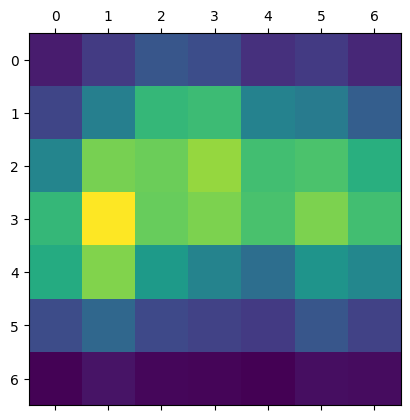

In [12]:
def compute_grad_cam(image_tensor,top_k=3):


    # Get the output using the  model
    output = resnet34(image_tensor)
    # Get the top  3  best scores
    probs, pred_classes = output.topk(top_k, 1, True, True)
    probs = torch.softmax(probs, dim=1).squeeze().cpu().detach().numpy()


    heatmaps = []
    for pred_class in pred_classes[0]:
        # Backpropagate gradients for the  best scores
        resnet34.zero_grad()
        output[:, pred_class].backward(retain_graph=True)


        # Grad-Class
        alpha = gradients.mean(dim=(2, 3), keepdim=True)
        activations = features_conv(image_tensor).detach()
        weighted_combination = torch.sum(alpha * activations, dim=1)
        heatmap = torch.relu(weighted_combination)
        # Normalize the heatmap
        heatmap /= torch.max(heatmap)
        heatmaps.append(heatmap.squeeze())

    return heatmaps, pred_classes.squeeze().cpu().numpy(), probs

image_path = dataset[index][0].view(1, 3, 224, 224)
heatmaps, pred_classes, probs = compute_grad_cam(image_path)

# Plot the heatmap
plt.matshow(heatmaps[0].detach().squeeze())
plt.show()


In [13]:
def plot_heatmap(htmp, pred_classes, probs):
  fig, (ax1,ax2,ax3) = plt.subplots(1,3)
  fig.set_size_inches(18,6)

  ax1.matshow(htmp[0].detach().squeeze())
  ax1.set_title("Heatmap-top-1: {} {:.2f}".format(pred_classes[0], float(probs[0])))
  ax2.matshow(htmp[1].detach().squeeze())
  ax2.set_title("Heatmap-top-2: {} {:.2f}".format(pred_classes[1], float(probs[1])))
  ax3.matshow(htmp[2].detach().squeeze())
  ax3.set_title("Heatmap-top-3: {} {:.2f}".format(pred_classes[2], float(probs[2])))
  plt.show()

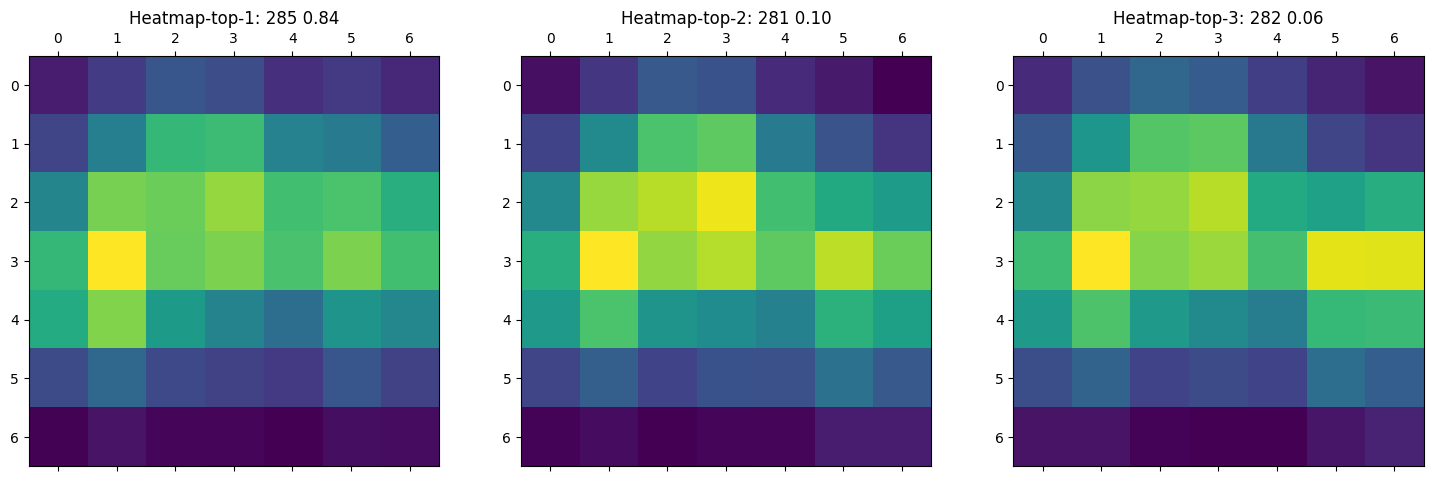

In [14]:
plot_heatmap(heatmaps, pred_classes, probs)


TODO
- upsamples your heatmaps using interpolation
- plot the overlay between the image and the upsampled heatmap

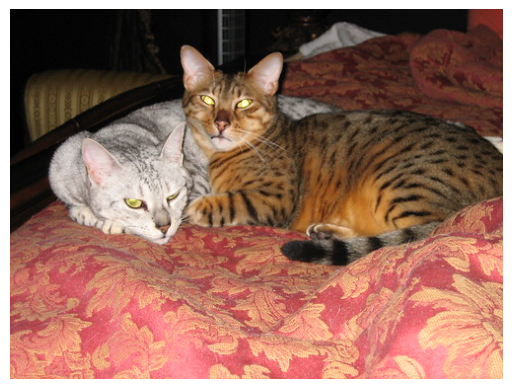

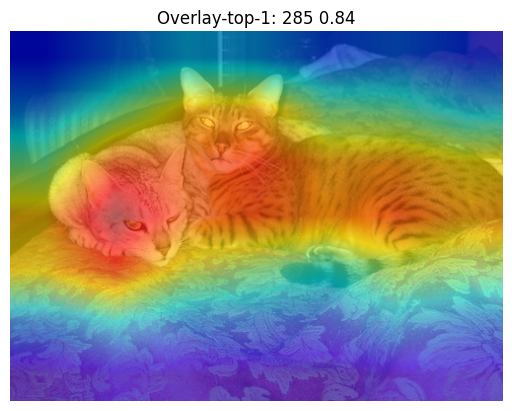

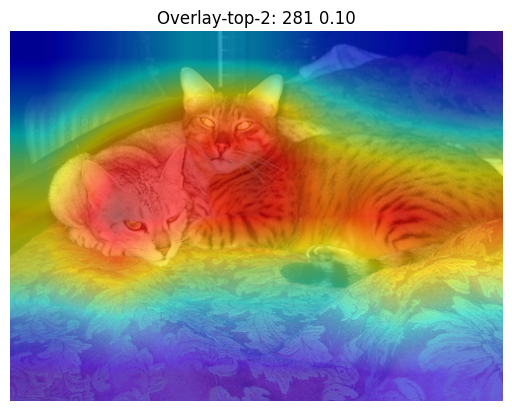

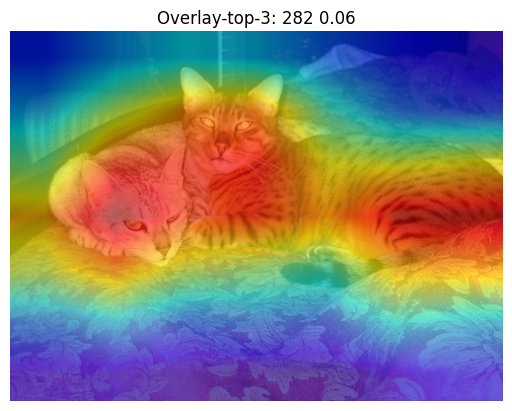

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def upsample_heatmap(heatmap, image_size):
    upsampled_heatmap = cv2.resize(heatmap, (image_size[1], image_size[0]))
    return upsampled_heatmap

def overlay_heatmap(image, heatmap, pred_class, prob, overlay_index):
    heatmap_rgb = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlaid_image = cv2.addWeighted(image, 0.4, heatmap_rgb, 0.6, 0)
    plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay-top-{overlay_index}: {pred_class} {prob:.2f}")
    plt.axis('off')
    plt.show()


image_path = "data/TP2_images/2637374064_fab14ec0b8.jpg"
image = cv2.imread(image_path)

upsampled_heatmaps = [upsample_heatmap(heatmap.detach().numpy(), image.shape[:2]) for heatmap in heatmaps]
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

for i,(upsampled_heatmap , pred_class, prob) in enumerate(zip(upsampled_heatmaps, pred_classes, probs),start=1):
    overlaid_image = overlay_heatmap(image, upsampled_heatmap,pred_class, prob,i)
